In [14]:
import matplotlib
matplotlib.use("qt4agg")
from bitfinex.backtest import data
from bitfinex import Client, TradeClient
import wget
import holoviews as hv

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
import backtrader
import pandas as pd
hv.notebook_extension('matplotlib')


In [3]:
TC = TradeClient()
C = Client()

Let's Start by checking my balances:

In [4]:
bals = pd.DataFrame(TC.balances())
bals

lALEKEwWBXdHMATLxMpJzWsUVISaAOuPkVnkK2BqnEr c333033775670bbe1294acca64324514cc59a690a6e893b1387b768f98e888b2f570eefd4aad0128d744bf32eaa356c6


,amount,available,currency,type
0,1.4391594,1.4391594,btc,exchange
1,0.0229278,0.0229278,usd,exchange
2,0.0,0.0,btc,trading


Let's Download some historic series:

In [5]:
wget.download('http://api.bitcoincharts.com/v1/csv/bitfinexUSD.csv.gz','bitfinexUSD.csv.gz' )

'bitfinexUSD.csv.gz'

In [7]:
history = data.CSVDataSource('bitfinexUSD.csv.gz',fields=['datetime', 'price', 'volume'])
history.parse_timestamp_column('datetime',unit='s')


In [8]:
print(history.data.info())
history.data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7580349 entries, 2013-03-31 22:07:48 to 2016-01-19 11:48:04
Data columns (total 2 columns):
price     float64
volume    float64
dtypes: float64(2)
memory usage: 173.5 MB
None


,price,volume
count,7580349.000000,7.580349e+06
mean,370.886261,2.643143e+00
std,173.052858,9.528200e+00
min,0.010000,1.000000e-08
25%,245.660000,9.340000e-02
50%,327.530000,5.000000e-01
75%,440.840000,2.000000e+00
max,1175.000000,2.333891e+03


Fake open, high, low, close data

In [9]:
history.data['open'] = history.data.price
history.data['high'] = history.data.price
history.data['low'] = history.data.price
history.data['close'] = history.data.price
history.data[:10]

,price,volume,open,high,low,close
datetime,,,,,,
2013-03-31 22:07:48,93.25,12.671482,93.25,93.25,93.25,93.25
2013-03-31 22:07:49,93.30,80.628518,93.30,93.30,93.30,93.30
2013-03-31 22:08:13,100.00,20.000000,100.00,100.00,100.00,100.00
2013-03-31 22:08:14,100.00,1.000000,100.00,100.00,100.00,100.00
2013-03-31 22:08:16,100.00,5.900000,100.00,100.00,100.00,100.00
2013-03-31 22:08:19,100.00,29.833879,100.00,100.00,100.00,100.00
2013-03-31 22:08:21,100.00,20.000000,100.00,100.00,100.00,100.00
2013-03-31 22:08:25,100.00,10.000000,100.00,100.00,100.00,100.00
2013-03-31 22:08:29,100.00,1.000000,100.00,100.00,100.00,100.00


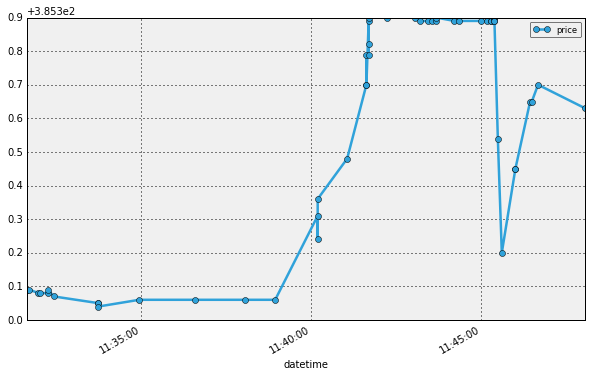

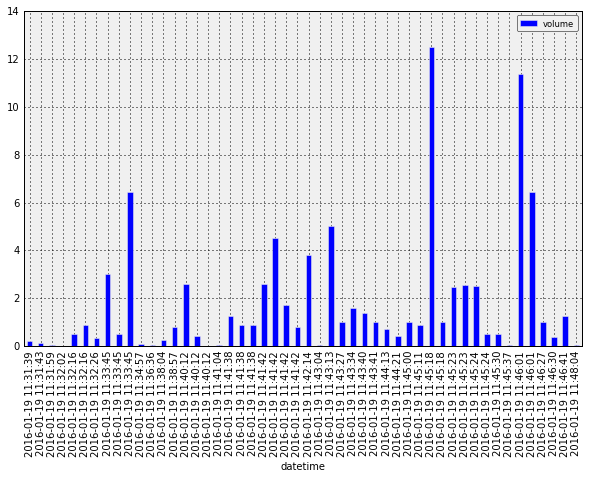

In [15]:
history.data[-50:].plot(y='price',figsize=(10,6), style='-o', grid=True);
history.data[-50:].plot(y='volume', kind='bar',figsize=(10,6), grid=True);

getting OHLC data

In [75]:
import json
d = json.load(open('bitfinex_ohlc.json'))
ohlc = pd.DataFrame(d, columns=['datetime', 'open','high','low','close','volume','volume_USD','weighted_price'])

ohlc.datetime = pd.to_datetime(ohlc.datetime, unit='s')
ohlc.set_index('datetime', inplace=True)
ohlc.to_csv('bitfinex_ohlc.csv')
ohlc[1:10]

,open,high,low,close,volume,volume_USD,weighted_price
datetime,,,,,,,
2013-04-01,93.170000,105.900000,92.49999,102.370000,4919.654127,492101.017274,100.027564
2013-04-02,102.800000,118.388067,99.00000,117.989990,9084.832816,987411.878008,108.687953
2013-04-03,116.579097,146.880000,101.51088,134.952969,12909.402178,1652091.861700,127.975861
2013-04-04,131.779686,143.000000,119.00000,132.681000,6910.100414,909438.515032,131.610029
2013-04-05,132.750000,145.000000,131.50300,140.000000,4838.184972,669393.366044,138.356299
2013-04-06,141.000000,144.000000,140.90200,143.990000,2170.750303,310410.792246,142.997005
2013-04-07,144.000000,174.400000,143.50100,174.400000,3735.130317,583658.176892,156.261797
2013-04-08,172.510000,200.000000,166.69300,194.500000,10616.275073,1935036.684257,182.270775
2013-04-09,190.510000,249.970000,188.89800,233.115000,6188.918894,1363071.275798,220.243842


Creating a strategy

In [16]:
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers

In [17]:
def run_test():
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    res = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    return res


In [83]:
class SMA_CrossOver(backtrader.Strategy):

    params = (('fast', 12), ('slow', 26))

    def __init__(self):
        self.rsi = btind.RSI()
        sma_fast = btind.SMA(period=self.p.fast)
        sma_slow = btind.SMA(period=self.p.slow)

        self.buysig = btind.CrossOver(sma_fast, sma_slow)

    def next(self):
        if self.position.size:
#             if (self.buysig < 0):
#                 self.sell()

#       elif (self.buysig > 0):
#                 self.buy()
            if (self.rsi<=50):
                self.sell()

        elif (self.rsi>=60):
            self.buy()

In [84]:
cerebro = backtrader.Cerebro()
cerebro.broker.setcash(100000.0)
data2 = backtrader.feeds.PandasData(dataname=history.data[-10000:], datetime=None)
cerebro.adddata(data2)
cerebro.broker.setcommission(commission=0.001)
cerebro.addstrategy(SMA_CrossOver)
#cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
res = run_test()
#print('Sharpe Ratio:', res[0].analyzers.mysharpe.get_analysis())

Starting Portfolio Value: 100000.00
Final Portfolio Value: 99887.84


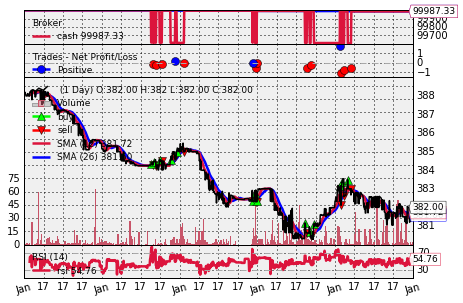

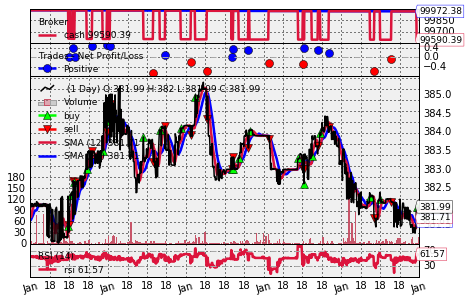

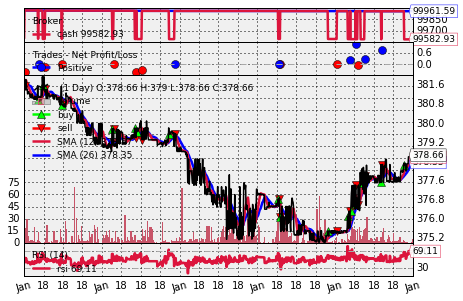

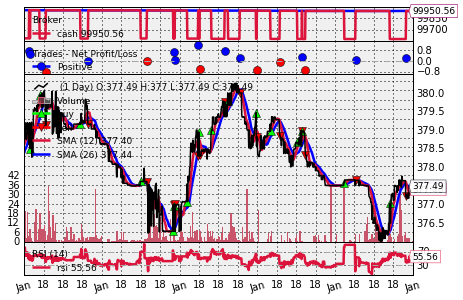

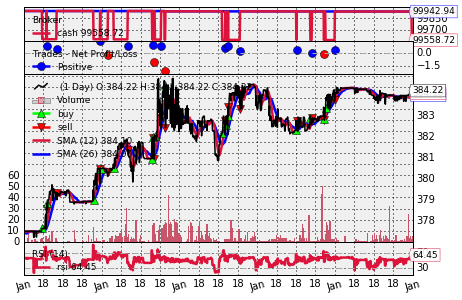

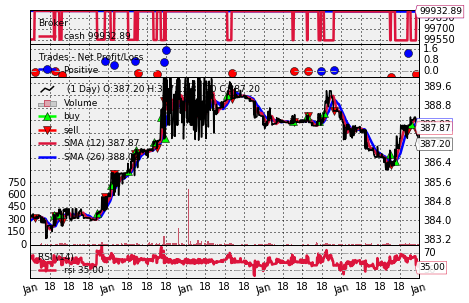

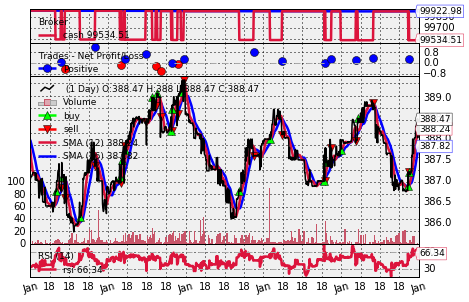

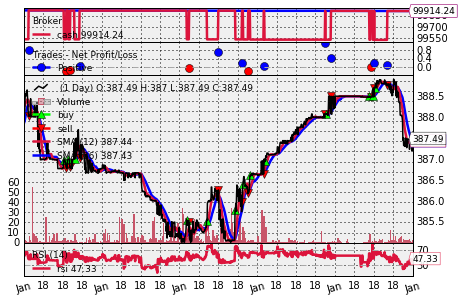

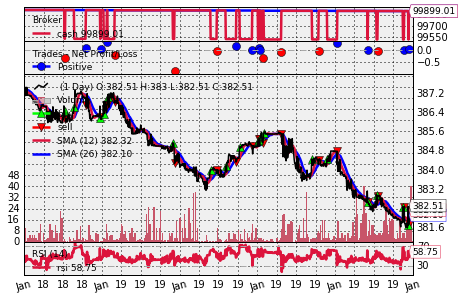

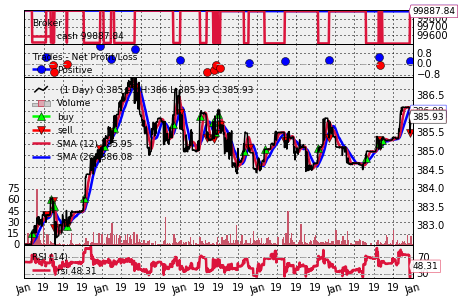

In [85]:
cerebro.plot(numfigs=10)


In [23]:
btind.RSI?